# From PCA to Autoencoders: Unsupervised representation learning

ISAE-Supaero filière SDD

Florent FOREST

forest@lipn.univ-paris13.fr

---

## Preparation

In [1]:
!git clone https://github.com/FlorentF9/Supaero-mlautoencoders.git

In [2]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
import numpy as np
import matplotlib.pyplot as plt
print('Torch version ', torch.__version__)

Torch version  1.1.0


In [3]:
# check is CUDA is available
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
device

device(type='cuda')

In [4]:
batch_size = 128
train_loader = DataLoader(MNIST('../data', train=True, download=True, transform=transforms.ToTensor()), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(MNIST('../data', train=False, transform=transforms.ToTensor()), batch_size=batch_size, shuffle=True)

## Let's code 1

<div style="color: #191; font-size: 16px; background-color: #dfd; padding: 20px; border-radius: 15px">
<p><b>Exercise</b></p>
<p>Implement a multi-layer (MLP) autoencoder using PyTorch by completing the following code snippet.</p>
<ol>
    <li>Try changing the number of layers, units per layer, and activation function, and observe the impact on the loss function.</li>
    <li>The following code uses a <b>gaussian MLP</b>, i.e. <b>linear output activation</b> + <b>mean squared error (MSE) loss</b>. Could we also use a Bernoulli distribution, with a <b>sigmoid output activation</b> + <b>cross-entropy loss</b>?</li>
    <li>Visualize the latent space using t-SNE, and compare it with the original data.</li>
</ol>
    
<p>If you have time left, you can also implement a <b>convolutional autoencoder</b>. You might guess it, convolutional and pooling layers will replace the fully-connected layers in the encoder. And what about the decoder?</p>
</div>

In [5]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(784, 200),
            nn.ReLU(True),
            nn.Linear(200, 10)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(10, 200),
            nn.ReLU(True),
            nn.Linear(200, 784),
            #nn.Sigmoid()
        )

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        return self.decode(self.encode(x))

### Training and evaluation

In [6]:
model = Autoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

loss_function = nn.MSELoss(reduction='sum')
#loss_function = nn.BCELoss(reduction='sum')

In [7]:
# training
epochs = 30
train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for i, (X_batch, _) in enumerate(train_loader):
        X_batch = X_batch.to(device).view(-1, 784)
        # forward
        X_pred = model(X_batch)
        loss = loss_function(X_pred, X_batch)
        # backward
        optimizer.zero_grad()
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    train_losses.append(train_loss / len(train_loader.dataset))
            
    print('Epoch: {} - Train loss: {}'.format(epoch, train_losses[-1]))

Epoch: 0 - Train loss: 26.468075671386718
Epoch: 1 - Train loss: 19.463041404215495
Epoch: 2 - Train loss: 18.279847969563804
Epoch: 3 - Train loss: 17.565231974283854
Epoch: 4 - Train loss: 17.059671189371745
Epoch: 5 - Train loss: 16.671136783854166
Epoch: 6 - Train loss: 16.382152549235027
Epoch: 7 - Train loss: 16.137542728678387
Epoch: 8 - Train loss: 15.939065083821614
Epoch: 9 - Train loss: 15.774253238932292
Epoch: 10 - Train loss: 15.615914365641276
Epoch: 11 - Train loss: 15.489866276041667
Epoch: 12 - Train loss: 15.365084973144532
Epoch: 13 - Train loss: 15.25812940266927
Epoch: 14 - Train loss: 15.154984800211588
Epoch: 15 - Train loss: 15.069216135660808
Epoch: 16 - Train loss: 14.983289501953125
Epoch: 17 - Train loss: 14.911350368245444
Epoch: 18 - Train loss: 14.83725767211914
Epoch: 19 - Train loss: 14.7758236714681
Epoch: 20 - Train loss: 14.710967635091146
Epoch: 21 - Train loss: 14.658118552652995
Epoch: 22 - Train loss: 14.606716715494791
Epoch: 23 - Train loss: 1

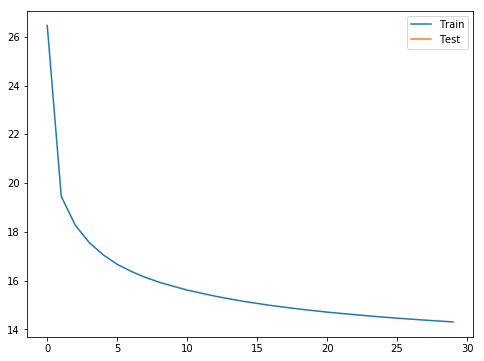

In [8]:
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train')
plt.legend();

In [9]:
# evaluation
model.eval()

test_loss = 0
with torch.no_grad():
    for i, (X_batch, _) in enumerate(test_loader):
        X_batch = X_batch.to(device).view(-1, 784)
        # forward
        X_pred = model(X_batch)
        test_loss += loss_function(X_pred, X_batch).item()
        
        if i == 0:
            n = min(X_batch.size(0), 8)
            comparison = torch.cat([X_batch.view(batch_size, 1, 28, 28)[:n], X_pred.view(batch_size, 1, 28, 28)[:n]])
            img = comparison.cpu().numpy()

print('Test loss: {}'.format(test_loss / len(test_loader.dataset)))

Test loss: 14.332766647338866


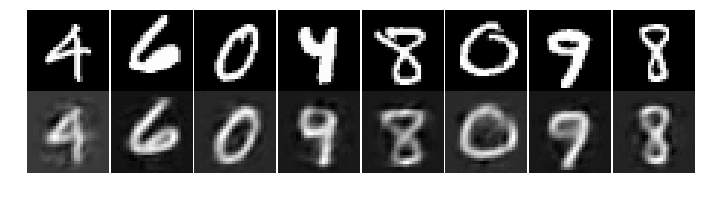

In [10]:
# visualize original VS reconstructed samples
n = img.shape[0] // 2
fig, ax = plt.subplots(2, n, figsize=(12, 3))
for i in range(n):
    ax[0][i].imshow(img[i, 0], cmap='gray')
    ax[1][i].imshow(img[n + i, 0], cmap='gray')
    ax[0][i].axis('off')
    ax[1][i].axis('off')
plt.subplots_adjust(hspace=0.0, wspace=0.0)

### Latent space visualization

In [11]:
from sklearn.manifold import TSNE

In [12]:
test_list = list(iter(test_loader))
X_test = np.vstack([x[0].view(-1, 784).numpy() for x in test_list])
y_test = np.vstack([x[1].view(-1, 1).numpy() for x in test_list])
del test_list
X_test.shape, y_test.shape

((10000, 784), (10000, 1))

In [13]:
# take a smaller sample for running t-SNE
N = 1000
sample_idx = np.random.permutation(np.arange(X_test.shape[0]))[:N]
X_sample = X_test[sample_idx]
y_sample = y_test[sample_idx].squeeze(1)

In [14]:
tsne = TSNE(n_components=2)
# apply t-SNE on raw samples
raw_tsne = tsne.fit_transform(X_sample)

In [15]:
with torch.no_grad():
    Z_sample = model.encode(torch.Tensor(X_sample).to(device)).cpu().numpy()

In [16]:
# apply t-SNE on encoded samples
ae_tsne = tsne.fit_transform(Z_sample)

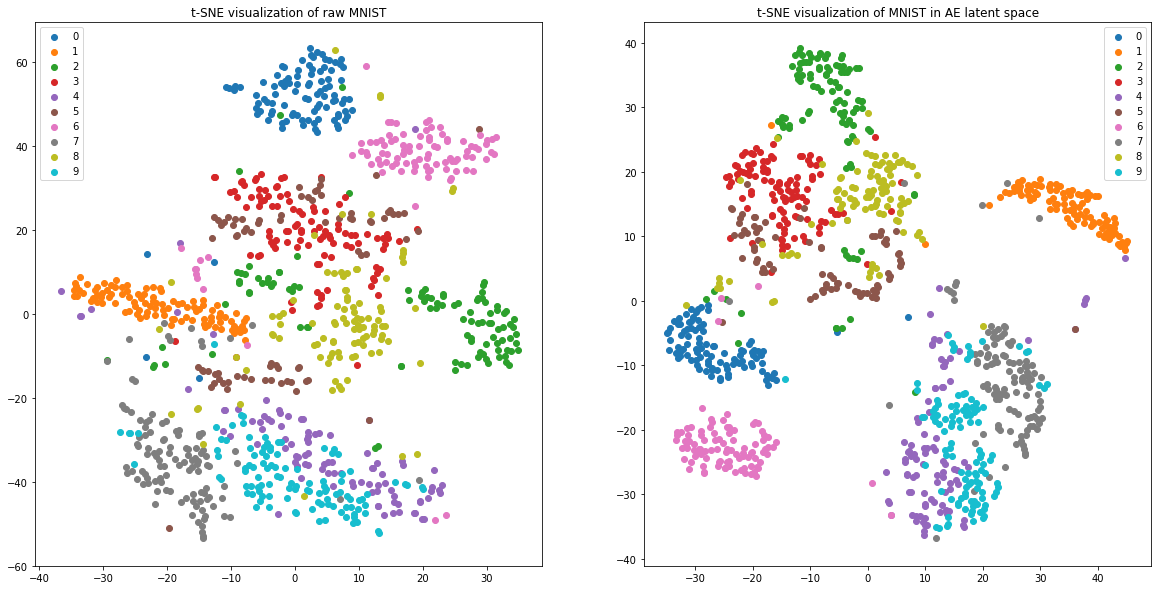

In [17]:
_, ax = plt.subplots(1, 2, figsize=(20,10))
for label in range(10):
    ax[0].scatter(raw_tsne[y_sample == label, 0], raw_tsne[y_sample == label, 1], label=label, cmap='Accent')
    ax[1].scatter(ae_tsne[y_sample == label, 0], ae_tsne[y_sample == label, 1], label=label, cmap='Accent')
ax[0].legend()
ax[0].set_title('t-SNE visualization of raw MNIST')
ax[1].legend()
ax[1].set_title('t-SNE visualization of MNIST in AE latent space');

### Impact on $k$-means clustering

In [18]:
from sklearn.utils.linear_assignment_ import linear_assignment

def _contingency_matrix(y_true, y_pred):
    w = np.zeros((y_true.max() + 1, y_pred.max() + 1), dtype=np.int64)
    for c, k in zip(y_true, y_pred):
        w[c, k] += 1  # w[c, k] = number of c-labeled samples in cluster k
    return w

def clustering_accuracy(y_true, y_pred):
    """Unsupervised clustering accuracy.

    Can only be used if the number of target classes in y_true is equal to the number of clusters in y_pred.

    Parameters
    ----------
    y_true : array, shape = [n]
        true labels.
    y_pred : array, shape = [n]
        predicted cluster ids.

    Returns
    -------
    accuracy : float in [0,1] (higher is better)
    """
    y_true = y_true.astype(np.int64)
    y_pred = y_pred.astype(np.int64)
    w = _contingency_matrix(y_true, y_pred).T
    ind = linear_assignment(w.max() - w)
    return np.sum([w[i, j] for i, j in ind]) / y_true.size

In [19]:
from sklearn.cluster import KMeans
y_pred = KMeans(n_clusters=10, n_jobs=-1).fit_predict(X_test)

with torch.no_grad():
    Z_test = model.encode(torch.Tensor(X_test).to(device)).cpu().numpy()
y_pred_ae = KMeans(n_clusters=10, n_jobs=-1).fit_predict(Z_test)

In [20]:
clustering_accuracy(y_test, y_pred)

0.5422

In [21]:
clustering_accuracy(y_test, y_pred_ae)

0.6193

---

## Let's code 2

<div style="color: #191; font-size: 16px; background-color: #dfd; padding: 20px; border-radius: 15px">
<p><b>Exercise</b></p>
<p>Implement a variational autoencoder (VAE) using PyTorch by completing the following code snippet.</p>
<ol>
    <li>Implement the reparameterization.</li>
    <li>Implement the VAE loss function. As in the standard AE, the reconstruction error can be either a <b>mean squared error (MSE)</b> (gaussian decoder) or a <b>binary cross-entropy loss</b> (Bernoulli decoder)</li>
    <li>Visualize the latent space using t-SNE, and compare it with the original data.</li>
</ol>
    
<p>If you have time left, you can also implement a <b>convolutional VAE</b>
</div>

In [22]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(784, 400),
            nn.ReLU(True)
        )
        self.mu = nn.Linear(400, 20)
        self.logvar = nn.Linear(400, 20)
        
        self.decoder = nn.Sequential(
            nn.Linear(20, 400),
            nn.ReLU(True),
            nn.Linear(400, 784),
            #nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.mu(h), self.logvar(h)

    def decode(self, z):
        return self.decoder(z)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

### Training and evaluation

In [23]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def loss_function(decoded_x, x, mu, logvar):
    # reconstruction error (MSE or BCE)
    RE = torch.nn.MSELoss(reduction='sum')(decoded_x, x)
    #RE = torch.nn.BCELoss(reduction='sum')(decoded_x, x)
    
    # Kullback-Leibler divergence error
    # see VAE paper: Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    KLD = - 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return RE + KLD

In [24]:
# training
epochs = 30
train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for i, (X_batch, _) in enumerate(train_loader):
        X_batch = X_batch.to(device).view(-1, 784)
        # forward
        X_pred, mu, logvar = model(X_batch)
        loss = loss_function(X_pred, X_batch, mu, logvar)
        # backward
        optimizer.zero_grad()
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    train_losses.append(train_loss / len(train_loader.dataset))
            
    print('Epoch: {} - Train loss: {}'.format(epoch, train_losses[-1]))

Epoch: 0 - Train loss: 42.53852958170573
Epoch: 1 - Train loss: 35.26929043782552
Epoch: 2 - Train loss: 34.145445275878906
Epoch: 3 - Train loss: 33.47372114664714
Epoch: 4 - Train loss: 32.98826177571615
Epoch: 5 - Train loss: 32.62453375651042
Epoch: 6 - Train loss: 32.32124019368489
Epoch: 7 - Train loss: 32.095796325683594
Epoch: 8 - Train loss: 31.890872322591147
Epoch: 9 - Train loss: 31.703143693033855
Epoch: 10 - Train loss: 31.571735998535157
Epoch: 11 - Train loss: 31.4400560546875
Epoch: 12 - Train loss: 31.329147798665364
Epoch: 13 - Train loss: 31.200108463541667
Epoch: 14 - Train loss: 31.132417232259115
Epoch: 15 - Train loss: 31.034196846516927
Epoch: 16 - Train loss: 30.984100069173177
Epoch: 17 - Train loss: 30.9083389444987
Epoch: 18 - Train loss: 30.81290583089193
Epoch: 19 - Train loss: 30.78948909098307
Epoch: 20 - Train loss: 30.7160294921875
Epoch: 21 - Train loss: 30.687411344401042
Epoch: 22 - Train loss: 30.646117598470052
Epoch: 23 - Train loss: 30.61237017

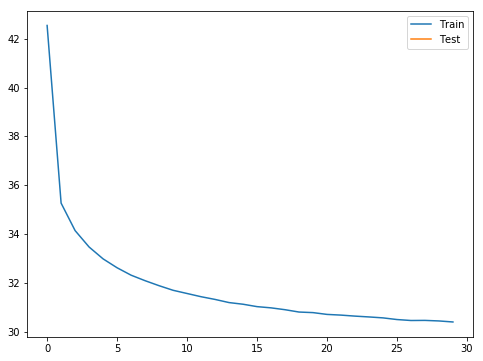

In [25]:
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train')
plt.legend();

In [26]:
# evaluation
model.eval()

test_loss = 0
with torch.no_grad():
    for i, (X_batch, _) in enumerate(test_loader):
        X_batch = X_batch.to(device).view(-1, 784)
        # forward
        X_pred, mu, logvar = model(X_batch)
        test_loss += loss_function(X_pred, X_batch, mu, logvar).item()
        
        if i == 0:
            n = min(X_batch.size(0), 8)
            comparison = torch.cat([X_batch.view(batch_size, 1, 28, 28)[:n], X_pred.view(batch_size, 1, 28, 28)[:n]])
            img = comparison.cpu().numpy()

print('Test loss: {}'.format(test_loss / len(test_loader.dataset)))

Test loss: 30.267160705566408


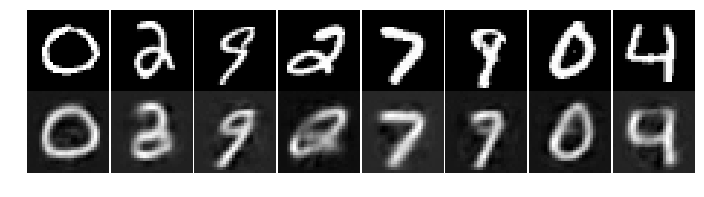

In [27]:
# visualize original VS reconstructed samples
n = img.shape[0] // 2
fig, ax = plt.subplots(2, n, figsize=(12, 3))
for i in range(n):
    ax[0][i].imshow(img[i, 0], cmap='gray')
    ax[1][i].imshow(img[n + i, 0], cmap='gray')
    ax[0][i].axis('off')
    ax[1][i].axis('off')
plt.subplots_adjust(hspace=0.0, wspace=0.0)

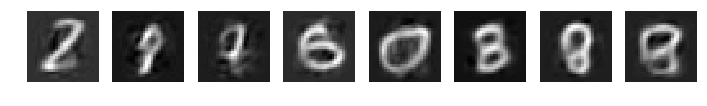

In [28]:
# generate some samples
n_samples = 8
with torch.no_grad():
    z = torch.randn(n_samples, 20).to(device)
    sample = model.decode(z).view(-1, 28, 28).cpu().numpy()

_, ax = plt.subplots(1, n_samples, figsize=(12, 4))
for i in range(n_samples):
    ax[i].imshow(sample[i], cmap='gray')
    ax[i].axis('off')

### Latent space visualization

In [29]:
with torch.no_grad():
    Z_sample = model.encode(torch.Tensor(X_sample).to(device))[0].cpu().numpy()

In [30]:
# apply t-SNE on encoded samples
vae_tsne = tsne.fit_transform(Z_sample)

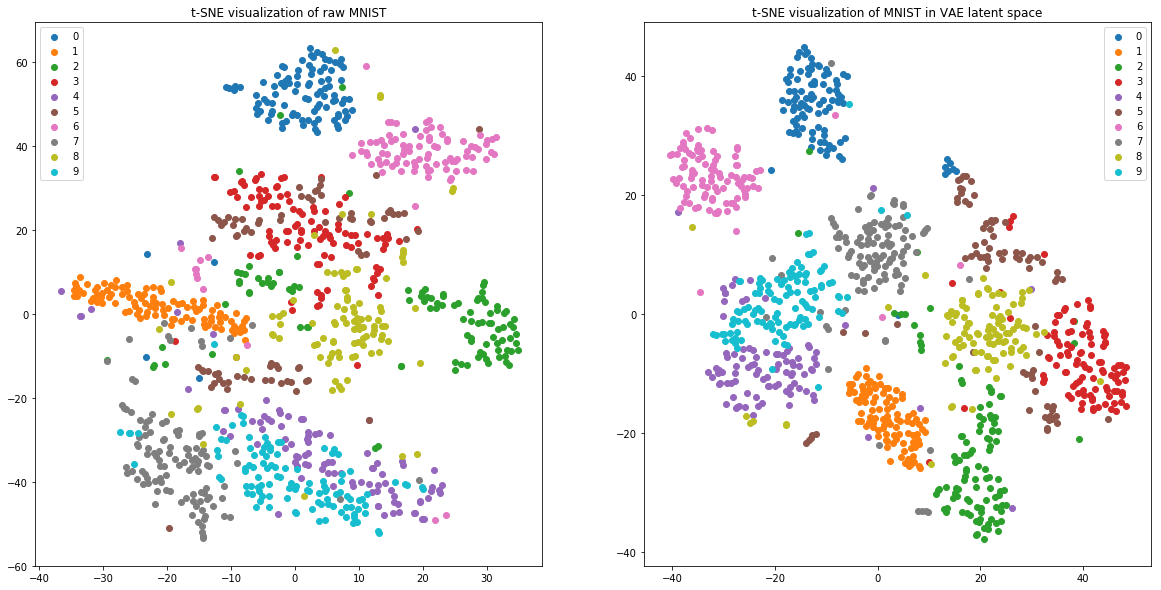

In [31]:
_, ax = plt.subplots(1, 2, figsize=(20,10))
for label in range(10):
    ax[0].scatter(raw_tsne[y_sample == label, 0], raw_tsne[y_sample == label, 1], label=label, cmap='Accent')
    ax[1].scatter(vae_tsne[y_sample == label, 0], vae_tsne[y_sample == label, 1], label=label, cmap='Accent')
ax[0].legend()
ax[0].set_title('t-SNE visualization of raw MNIST')
ax[1].legend()
ax[1].set_title('t-SNE visualization of MNIST in VAE latent space');

### Impact on $k$-means clustering

In [32]:
y_pred = KMeans(n_clusters=10, n_jobs=-1).fit_predict(X_test)

with torch.no_grad():
    Z_test = model.encode(torch.Tensor(X_test).to(device))[0].cpu().numpy()  
y_pred_vae = KMeans(n_clusters=10, n_jobs=-1).fit_predict(Z_test)

In [33]:
clustering_accuracy(y_test, y_pred)

0.5502

In [34]:
clustering_accuracy(y_test, y_pred_vae)

0.7122